<a href="https://colab.research.google.com/github/tmkhang1999/1990-2023-Vaccine-Analytics/blob/main/Vaccine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Libraries

In [ ]:
import math
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder

# 2. Loading Dataset

In this project, I need to download the "vaccine" dataset from https://vaers.hhs.gov/data/datasets.html to explore the relations among features. More specifically, the vaccine records include the patients, symptoms and vaccine data from 1990 to 2023 as below:


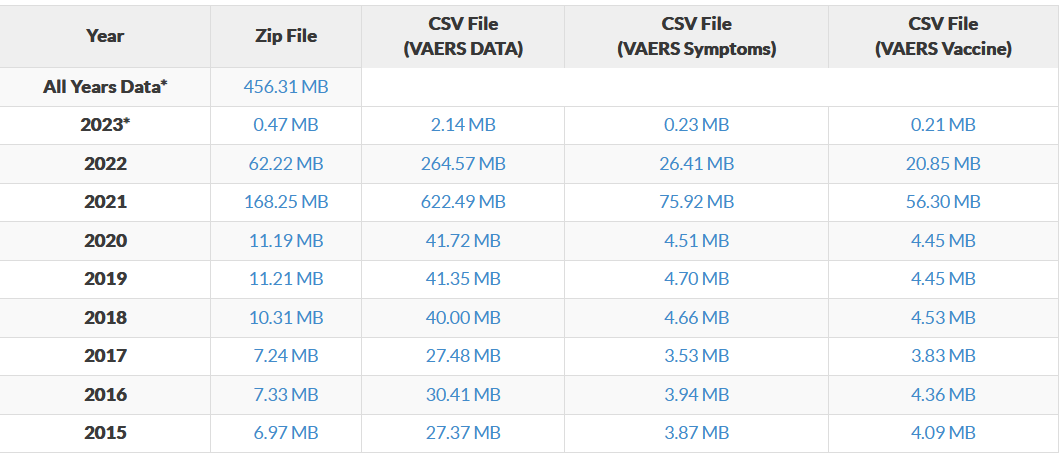

## 2.1. Combine Patient + Vaccine

In [ ]:
# Merge the patient and vaccine datasets based on "VAERS_ID" for each year, 
# then concatenate the year subjects along the column axis.

# Define variables
ENCODING = 'cp1252'
dataset_path = "./dataset"
df_1 =  pd.DataFrame()

# Iterate through each year folder
for year_folder in os.listdir(dataset_path):
    year_path = os.path.join(dataset_path, year_folder)

    # Iterate through 3 files in folder
    for data_file in os.listdir(year_path):
        data_path = os.path.join(year_path, data_file)

        # Extract the patient data
        if data_file.endswith("DATA.csv"):
           patient = pd.read_csv(data_path, encoding=ENCODING)

        # Extract the vaccine data
        if data_file.endswith("VAX.csv"):
           vaccine = pd.read_csv(data_path, encoding=ENCODING)

    # Merge patient and vaccine data
    year_data = pd.merge(patient, vaccine, on='VAERS_ID')
    df_1 = pd.concat((df_1, year_data)).reset_index(drop=True)

In [ ]:
df_1.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,518048,01/01/2014,OH,43.00,43.0,NaN,F,01/01/2014,Hot pain at injection site; fever; fatigue; he...,NaN,...,NaN,NaN,NaN,FLU4,GLAXOSMITHKLINE BIOLOGICALS,NaN,1,SYR,LA,INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT)
1,518049,01/01/2014,ME,1.11,1.0,0.1,M,01/01/2014,"Red, hard bump at sight of injection.",NaN,...,NaN,NaN,NaN,VARCEL,UNKNOWN MANUFACTURER,NaN,1,UN,LL,VARICELLA (NO BRAND NAME)
2,518050,01/01/2014,TX,60.00,60.0,NaN,F,01/01/2014,"Fast heart rate, head ache, weakness, fever.",NaN,...,NaN,NaN,NaN,JEVX,UNKNOWN MANUFACTURER,NaN,1,UN,LA,JAPANESE ENCEPHALITIS (NO BRAND NAME)
3,518051,01/01/2014,GA,0.78,0.0,0.8,M,01/01/2014,Baby had a hard time swallowing food and bottl...,NaN,...,NaN,NaN,NaN,HEP,UNKNOWN MANUFACTURER,NaN,4,SYR,LL,HEP B (NO BRAND NAME)
4,518052,01/01/2014,TX,32.00,32.0,NaN,F,01/01/2014,"Severe ongoing headaches, severe vomiting afte...",NaN,...,NaN,NaN,NaN,FLU3,SANOFI PASTEUR,NaN,1,IM,LA,INFLUENZA (SEASONAL) (FLUZONE)


In [ ]:
df_1.shape

(1956865, 42)

## 2.2. Combine Patient + Symtomps

In [ ]:
# Define variables
chosen_year = '2022'
ENCODING = 'cp1252'
dataset = "./dataset"
df_2 =  pd.DataFrame()

# Iterate through each year folder
for year in os.listdir(dataset):
    
    # Get the data in the year you'd like to analyze
    if year == chosen_year:
        year_path = os.path.join(dataset, year)

        # Iterate through 3 files in folder
        for data_file in os.listdir(year_path):
            data_path = os.path.join(year_path, data_file)

            # Extract the patient data
            if data_file.endswith("DATA.csv"):
              patient = pd.read_csv(data_path, encoding=ENCODING)
              patient = patient[['VAERS_ID', "AGE_YRS", "SEX", "L_THREAT", "DIED"]]

            # Extract the symptom data
            if data_file.endswith("SYMPTOMS.csv"):
              symptom = pd.read_csv(data_path, encoding=ENCODING)
              symptom = symptom.drop(columns=["SYMPTOMVERSION1", "SYMPTOMVERSION2", "SYMPTOMVERSION3", "SYMPTOMVERSION4", "SYMPTOMVERSION5"])
              symptom = symptom.set_index("VAERS_ID").unstack().dropna().reset_index(name='SYMPTOMS')[["VAERS_ID", "SYMPTOMS"]].groupby("VAERS_ID").agg(lambda x: list(x))
              symptom = symptom.reset_index()

        # Merge the 
        year_data = pd.merge(patient, symptom, on='VAERS_ID')
        df_2 = pd.concat((df_2, year_data)).reset_index(drop=True)

# 3. Data Cleaning

## 3.1. Checking the NaN values

Text(0.5, 1.0, 'Percent missing data by feature')

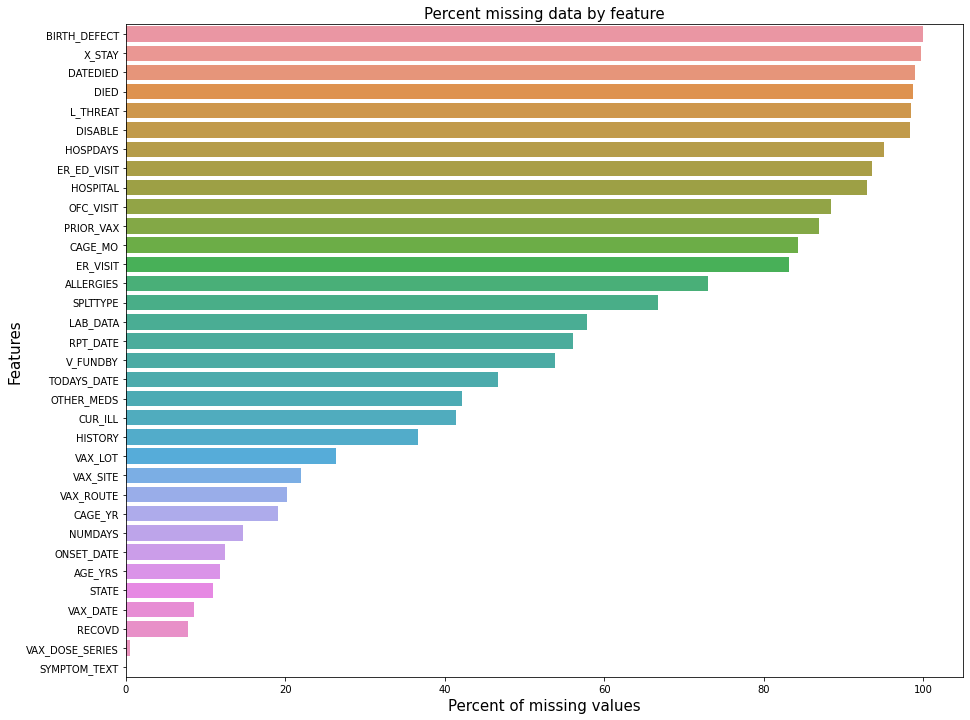

In [ ]:
# Calculate the percentage of the missing values in each column, then put it
# into a data frame
df1_na = (df_1.isnull().mean()) * 100
df1_na = df1_na.drop(df1_na[df1_na == 0].index).sort_values(ascending=False)

# Setting figure size and seaborn style
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(x=df1_na, y=df1_na.index)

# Custom the chart
plt.xlabel('Percent of missing values', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

## 3.2. Drop unwanted columns

In [ ]:
# Drop the features with the missing value rate above 80%
df_1.drop(df1_na[df1_na > 80].index.drop("DIED"), axis=1, inplace=True)

In [ ]:
# Drop unnecessary features
for col in ['RPT_DATE', 'V_FUNDBY', 'TODAYS_DATE', 'ONSET_DATE', 'VAX_DATE']:
    df_1 = df_1.drop(col, axis=1)

## 3.3. Impute missing data

In [ ]:
# Replace all types of "NULL" values with "None"
all_data = all_data.replace(['none', 'none.', 'NONE', 'None.', 'none yet', 'none yet.', 
                             'None yet', 'None yet.', 'none known', 'None known', 'none reported', 
                             'None reported', 'None at this time', 'no', 'No', 
                             'unknown',  'U', 'UN', 'Unknown', 'UNKNOWN', 'UNK', 'N/a', 'na', 'Na', 
                             'NO'], 'None')

In [ ]:
# Fill NA values with "None" in "Yes-No" features
for col in ['DIED', 'RECOVD']:
    all_data[col] = all_data[col].fillna("N")

# Fill NA values with "None" in the features of VAERSVAX dataset
for col in ['VAX_LOT', 'VAX_SITE', 'VAX_ROUTE', 'VAX_DOSE_SERIES']:
    all_data[col] = all_data[col].fillna('None')

In [ ]:
# Fill NA values with "0" in "Age of Patient" features
all_data['AGE_YRS'] = all_data['AGE_YRS'].fillna(0)
all_data['CAGE_YR'] = all_data['CAGE_YR'].fillna(0)

# Fill NA values with "0" in "The number of days" features 
all_data['NUMDAYS'] = all_data['NUMDAYS'].fillna(0)

In [ ]:
# Fill NA values with "None" in the rest of features 
for col in ['ALLERGIES', 'SPLTTYPE', 'LAB_DATA', 'OTHER_MEDS' , 'CUR_ILL', 'HISTORY', 'STATE', 'SYMPTOM_TEXT']:
    all_data[col] = all_data[col].fillna('None')

## 3.4. Add other features to 'SYMPTOMS'

In [ ]:
for idx in range(len(df_2)):
    data = df_2.iloc[idx]
    symptom = data['SYMPTOMS']

    # age groups
    if not math.isnan(data['AGE_YRS']):
        age = math.floor(data['AGE_YRS']/10)
        symptom.append("{} - {} years".format(age*10, age*10+9))

    # gender
    if data['SEX'] == "F":
        symptom.append("Female")
    elif data['SEX'] == "M":
        symptom.append("Male")

    # threatening illness
    if data['L_THREAT'] == "Y":
        symptom.append("Threatening Illness")

    # death
    if data['DIED'] == "Y":
        symptom.append("DIED")

## 3.5. One-hot Encoding

In [ ]:


encoder = TransactionEncoder().fit(df_2['SYMPTOMS'].tolist())
df2_onehot = encoder.transform(df_2['SYMPTOMS'].tolist())
df2_onehot = pd.DataFrame(df2_onehot, columns=encoder.columns_)
df2_onehot

,0 - 9 years,10 - 19 years,100 - 109 years,17-hydroxyprogesterone,20 - 29 years,30 - 39 years,40 - 49 years,50 - 59 years,60 - 69 years,70 - 79 years,...,X-ray with contrast upper gastrointestinal tract,X-ray with contrast upper gastrointestinal tract abnormal,Xanthoma,Yawning,Yellow skin,Zinc deficiency,pH body fluid,pH body fluid abnormal,pH urine,pH urine normal
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54791,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
54792,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
54793,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
54794,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# 4. Data Visualization

## 4.1. The number of case in each vaccine type

In [ ]:
# Have a look at the value counts
all_data['VAX_TYPE'].value_counts()

COVID19    803835
VARZOS      99822
FLU3        93779
VARCEL      80324
MMR         79703
            ...  
H5N1            5
TBE             3
SSEV            3
CEE             1
MNC             1
Name: VAX_TYPE, Length: 96, dtype: int64

Text(0.5, 1.0, 'The number of patient on each vaccine type except COVID-19')

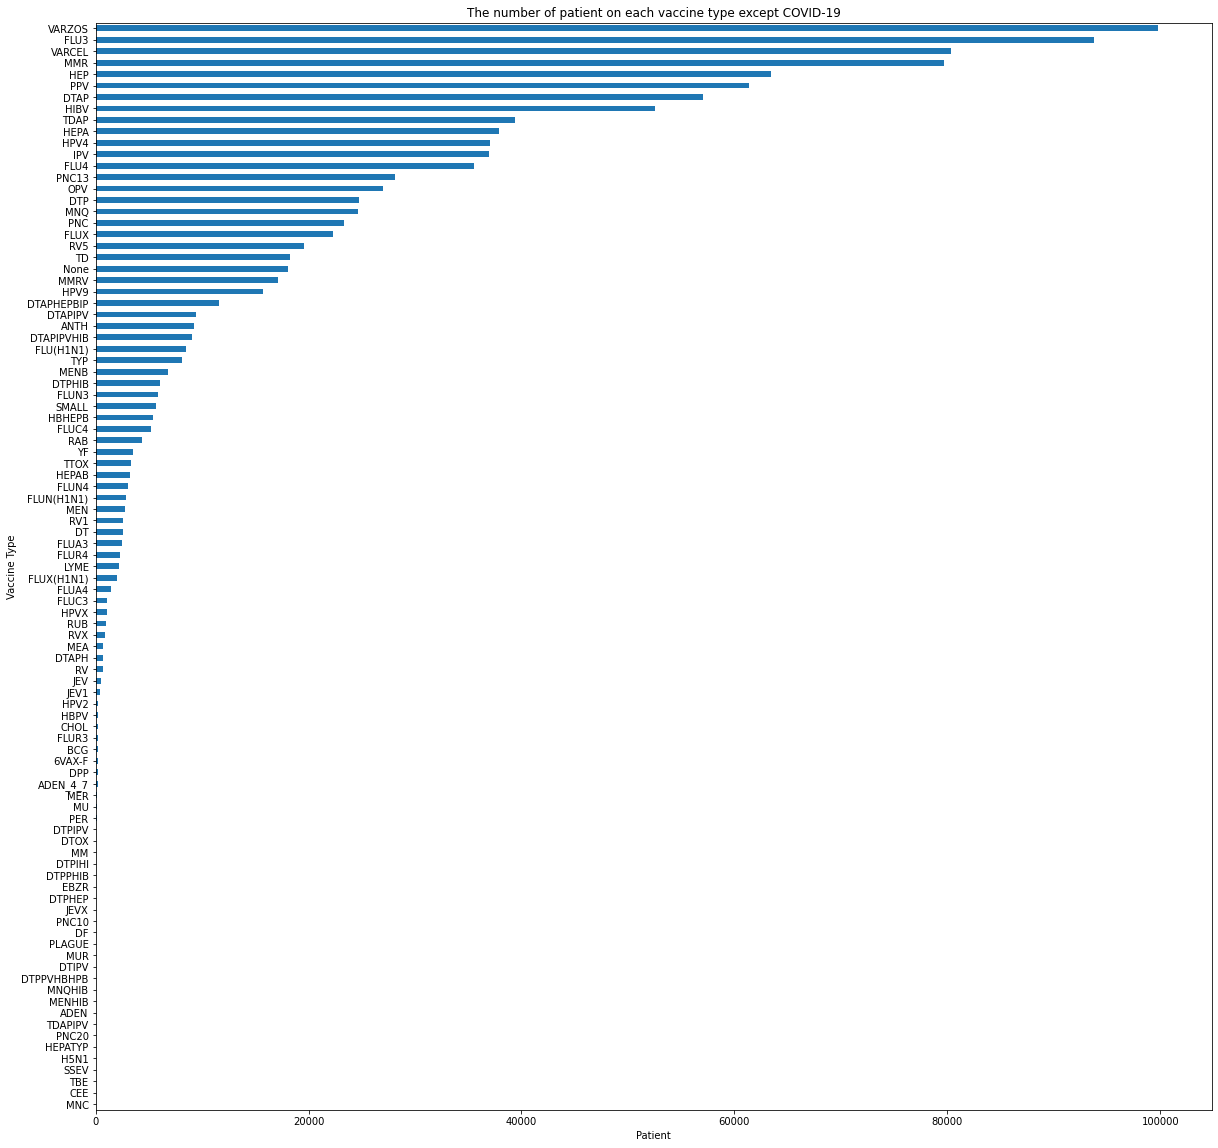

In [ ]:
# Build a bar chart showing the number of case on each vaccine type except COVID-19
all_data_except_covid = all_data.drop(all_data[all_data['VAX_TYPE'] == 'COVID19'].index, axis=0)
case_data = all_data_except_covid['VAX_TYPE'].value_counts().sort_values(ascending=True)
case_data.plot(kind='barh', figsize=(20, 20))

# Custom the chart
plt.xlabel('Patient')
plt.ylabel('Vaccine Type')
plt.title('The number of patient on each vaccine type except COVID-19')

## 4.2. The relationship between the number of death, vaccine type, and state using age and year filters in Plotly Dashboard

In [ ]:
# Install plotly dash for jupyter
!pip install jupyter-dash -q
!pip install dash-cytoscape -q

In [ ]:
# Import required packages
from datetime import date
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
from dash.dependencies import Input, Output

In [ ]:
# Custom 'SEX' feature
all_data['SEX'].replace(['F','M'], ['Female', 'Male'], inplace=True)

In [ ]:
# Calculate the max_time and min_time for date picker
all_data['RECVDATE'] = pd.to_datetime(all_data['RECVDATE'])
max_time = all_data['RECVDATE'].max()
min_time = all_data['RECVDATE'].min()

# Calculate the max_age and min_age for age slider
max_age = all_data['AGE_YRS'].max()
min_age = all_data['AGE_YRS'].min()

In [ ]:
# Create a dash application
app = JupyterDash(__name__)
app.config.suppress_callback_exceptions = True

# Create an app layout
app.layout = html.Div(children=[
    # Add title to the dashboard
    html.H1('Vaccine Death Records Dashboard',
            style={'textAlign': 'center', 'color': '#FF0000', 'font-size': 40}),

    # Create an outer division
    html.Div([
        # Add the division for choosing age
        html.Div([
            html.H2("Age:"),
            dcc.RangeSlider(
                id='age-slider',
                min=0,
                max=120,
                step=10,
                value=[min_age, max_age]
            ),
        ]),
        
        # Add the next division for choosing time
        html.Div([
            html.H2("Time Range:"),
            dcc.DatePickerRange(
                id='date-picker-range',
                min_date_allowed = min_time,
                max_date_allowed = max_time,
                initial_visible_month = date(2010, 6, 27),
                end_date = max_time
            ),
        ]),
    ]),

    # Add computed graph
    html.Br(),
    html.Div([
        html.Div([ ], id='plot-1'),
        html.Div([ ], id='plot-2')
    ], style={'display': 'flex'}),
])

# Add a callback function for `gender, age-group, received-year` as input, `record-chart` as output
@app.callback([Output(component_id='plot-1', component_property='children'),
               Output(component_id='plot-2', component_property='children')],
              
              [Input(component_id='age-slider', component_property='value'),
               Input(component_id='date-picker-range', component_property='start_date'),
               Input(component_id='date-picker-range', component_property='end_date')]
              )

def get_graph(age, start_date, end_date):
    # Compute required information for creating graph from the data
    filtered_df = all_data.drop(all_data[all_data['VAX_TYPE'] == 'COVID19'].index, axis=0)
    filtered_df = filtered_df[filtered_df['DIED'] == 'Y']
    filtered_df = filtered_df[filtered_df['AGE_YRS'].between(age[0], age[1])]
    filtered_df = filtered_df.loc[(filtered_df['RECVDATE'] > start_date) & (filtered_df['RECVDATE'] <= end_date)]

    # Group the data by vaccine type and sex. Compute total number of deaths in each combination
    bar_data = filtered_df.groupby(['VAX_TYPE', 'SEX'])['DIED'].count().reset_index()

    bar_fig = px.bar(bar_data, x="VAX_TYPE", y="DIED", color="SEX", 
            title='Total number of deaths by vaccine types')
    
    bar_fig.update_xaxes(tickangle=60)

    # Group the data by state, then compute the number of deaths in each state using choropleth
    map_data = filtered_df.groupby(['STATE'])['DIED'].count().reset_index()

    map_fig = px.choropleth(map_data, 
                            locations='STATE', 
                            color='DIED',  
                            hover_data=['STATE', 'DIED'], 
                            locationmode = 'USA-states',
                            color_continuous_scale='GnBu',
                            range_color=[0, map_data['DIED'].max()]) 

    map_fig.update_layout(
        title_text = 'Number of deaths from different states',
        geo_scope='usa')

    return [dcc.Graph(figure=bar_fig), 
            dcc.Graph(figure=map_fig)]

# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline', port=8000)

<IPython.core.display.Javascript object>

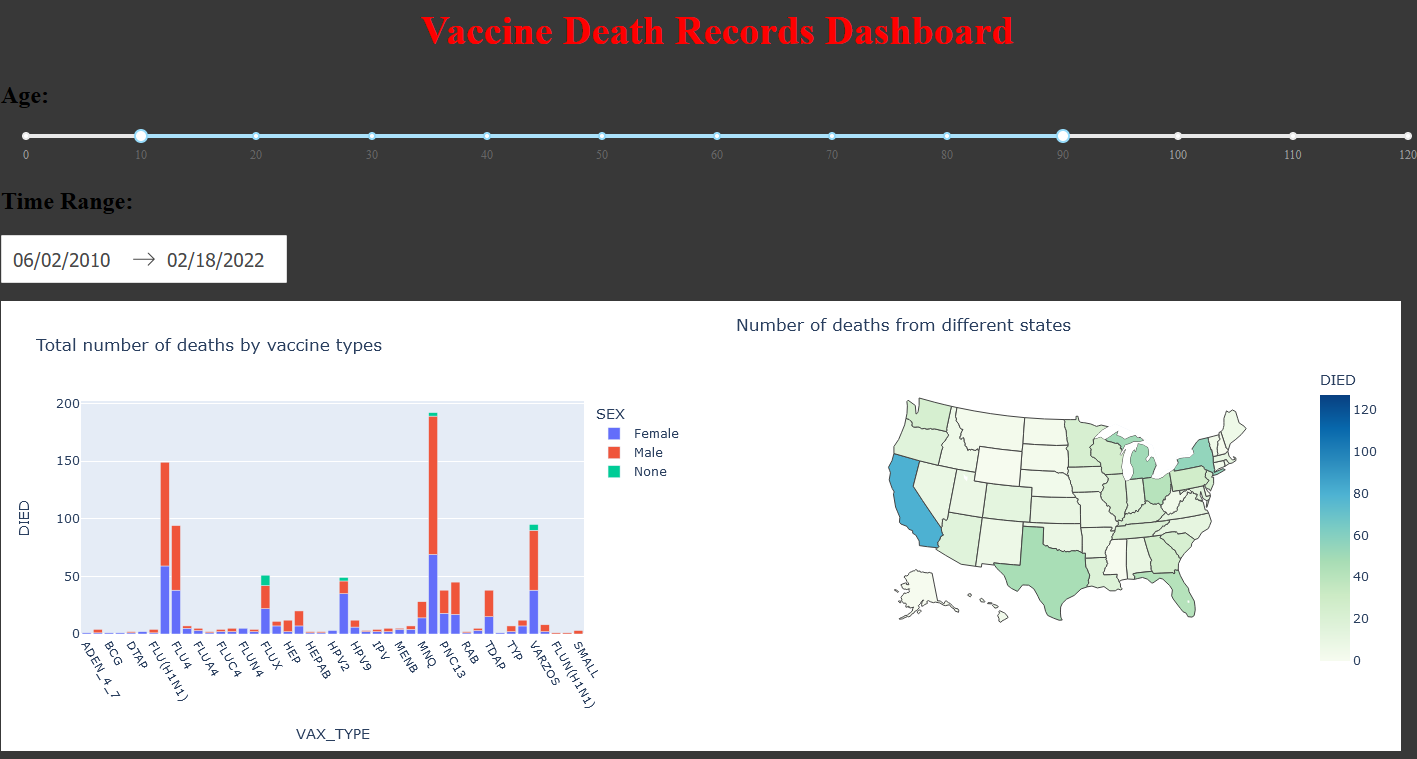

# 5. Association rules

## 5.1. Define association method

In [ ]:
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules

def association(data, method="apriori", drop_group=list(), min_support=0.01, metric="lift", min_threshold=1, max_len=None):
    if method == "apriori":
        frq_items = apriori(data.drop(drop_group, axis=1), min_support = min_support, use_colnames=True, max_len=max_len)
    elif method == "fpgrowth":
        frq_items = fpgrowth(data.drop(drop_group, axis=1), min_support = min_support, use_colnames=True, max_len=max_len)

    rules = association_rules(frq_items, metric=metric, min_threshold=min_threshold)
    rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
    rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
    rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
    return rules

In [ ]:
gender_group = ["Male", "Female"]
age_group = ["0 - 9 years", "10 - 19 years", "20 - 29 years", "30 - 39 years", "40 - 49 years", "50 - 59 years", "60 - 69 years", "70 - 79 years", "80 - 89 years", "90 - 99 years"]

## 5.2. Apriori algorithm

### 5.2.1 Top 10 rules for symptom

In [ ]:
symptom_rules = association(data=onehot, method="apriori",
                            drop_group=gender_group + age_group + ["DIED", "Death", "SARS-CoV-2 test positive"],
                            min_support=0.01, metric="lift", min_threshold=1)

# Top 10 significant rules for symptom
symptom_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by=['support'], ascending=False)[:10]

,antecedents,consequents,support,confidence,lift
33,Pyrexia,Chills,0.033816,0.368316,5.913351
32,Chills,Pyrexia,0.033816,0.542924,5.913351
53,Fatigue,Headache,0.032265,0.345921,3.568348
52,Headache,Fatigue,0.032265,0.332831,3.568348
73,Pyrexia,Headache,0.030568,0.332936,3.434403
72,Headache,Pyrexia,0.030568,0.315324,3.434403
87,Pyrexia,Pain,0.029509,0.321407,3.534384
86,Pain,Pyrexia,0.029509,0.324503,3.534384
69,Pain,Headache,0.028396,0.312262,3.221139
68,Headache,Pain,0.028396,0.292922,3.221139


### 5.2.2 Visualize Symptom Analysis

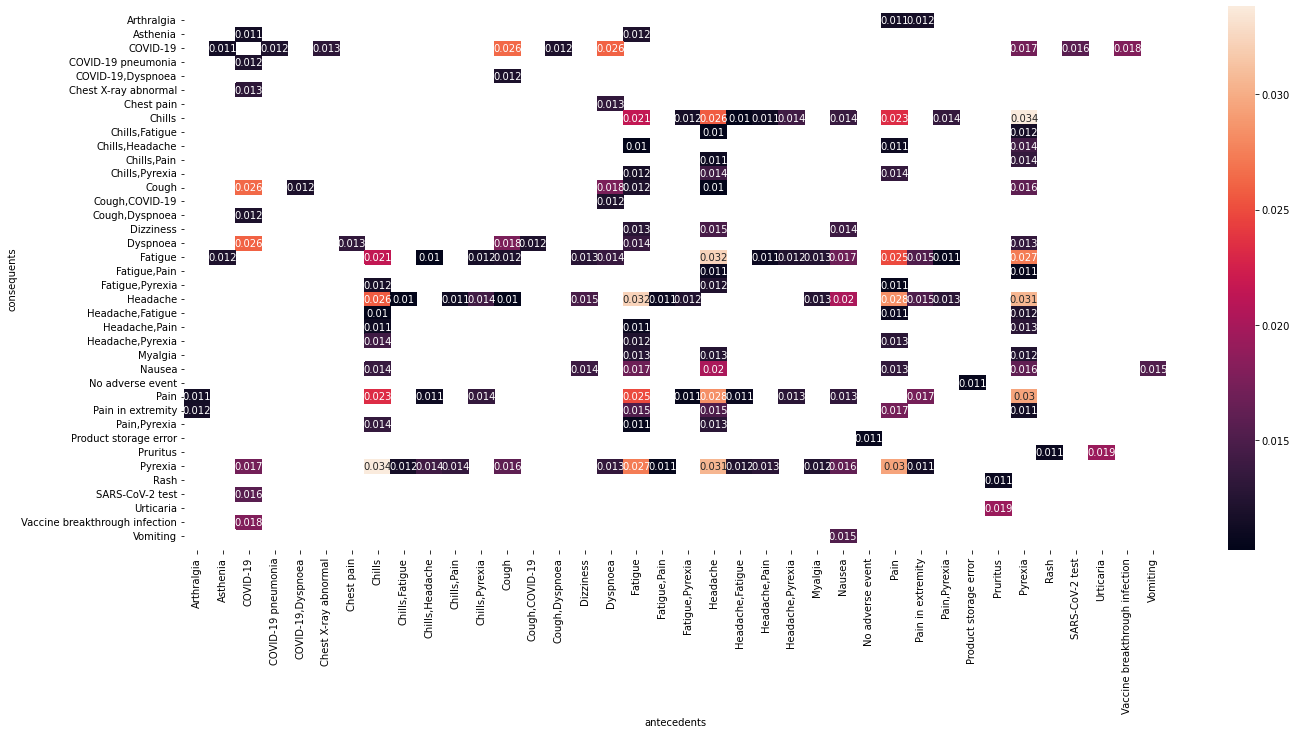

In [ ]:
# Transform the DataFrame of rules into a matrix using the support metric
support_table = symptom_rules.pivot(index='consequents', columns='antecedents', values='support')

# Build graph
plt.figure(figsize=(22,10))
sns.heatmap(support_table, annot=True)
b, t = plt.ylim() 
b += 0.5
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.show()

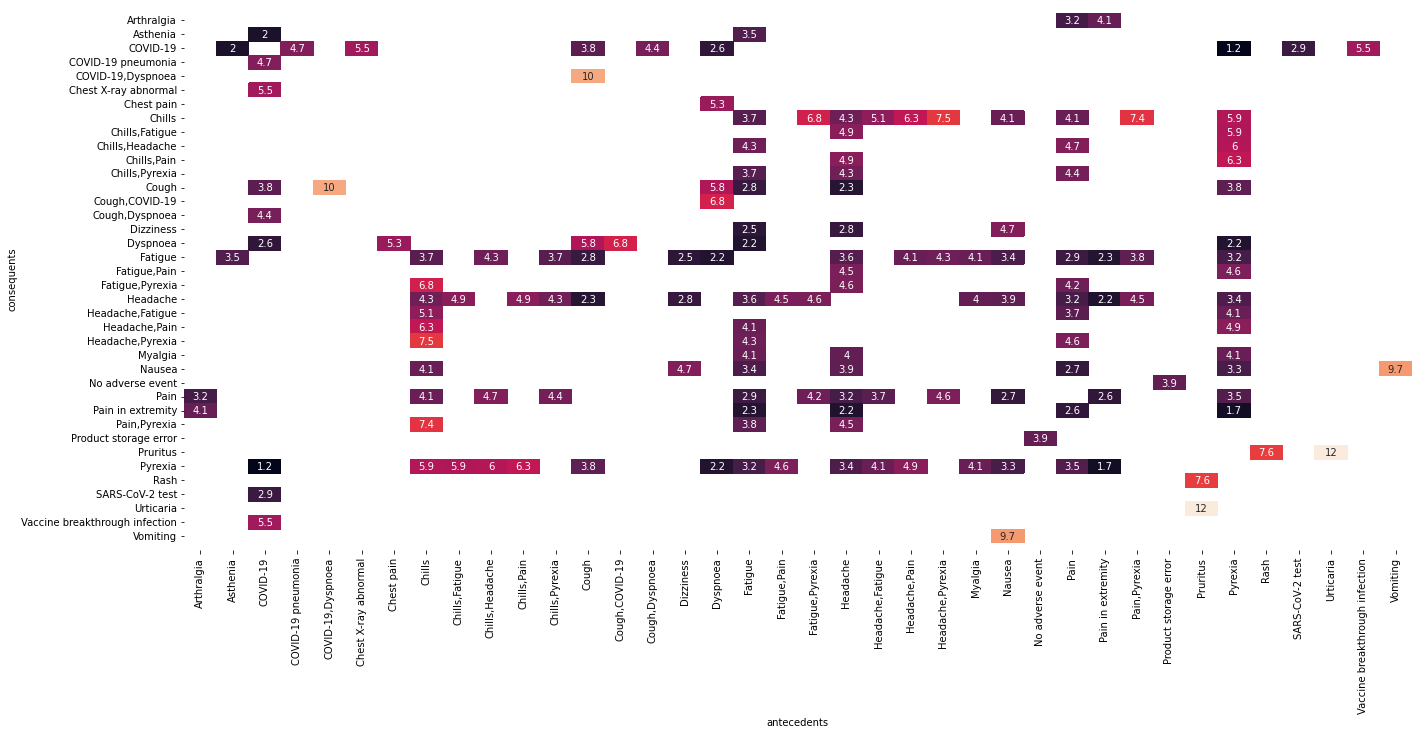

In [ ]:
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = symptom_rules.pivot(index = 'consequents', columns = 'antecedents', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(22,10))
sns.heatmap(pivot, annot = True, cbar = False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

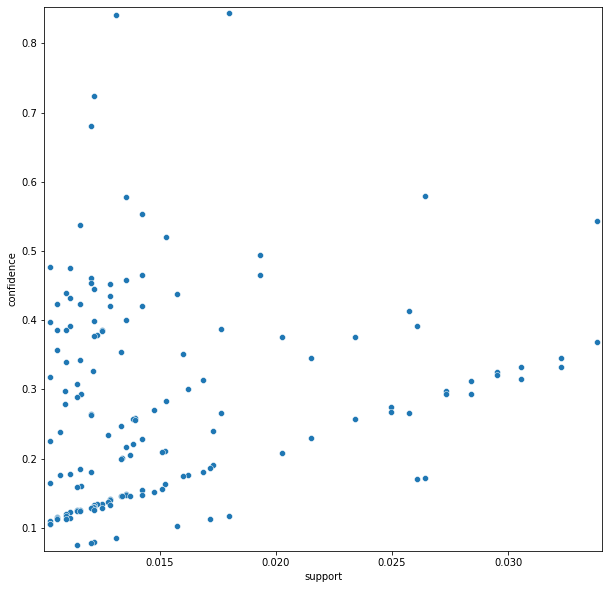

In [ ]:
# Generate scatterplot using support and confidence
plt.figure(figsize=(10,10))
sns.scatterplot(x="support", y="confidence", data=symptom_rules)
plt.margins(0.01,0.01)
plt.show()

### 5.2.3 Top 10 symptom rules dis-aggregated by 'SEX'

In [ ]:
gender_rules = association(data=onehot, method="apriori", 
                    drop_group=age_group + ["DIED", "Death", "SARS-CoV-2 test positive"], 
                    min_support=0.01, metric="lift", min_threshold=1)    

In [ ]:
gender_rules[gender_rules['consequents'] == 'Male'][['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by=['support'], ascending=False)[:10]

,antecedents,consequents,support,confidence,lift
364,COVID-19,Male,0.065698,0.429441,1.221534
427,Product storage error,Male,0.027539,0.454244,1.292088
380,Dyspnoea,Male,0.026900,0.404501,1.150592
2,No adverse event,Male,0.019144,0.427465,1.215915
332,Cough,Male,0.017410,0.382058,1.086756
0,Expired product administered,Male,0.017355,0.352876,1.003747
415,Chest pain,Male,0.015512,0.413424,1.175975
406,Asthenia,Male,0.014198,0.382686,1.088541
7,SARS-CoV-2 test,Male,0.012884,0.358740,1.020427
391,"COVID-19,Dyspnoea",Male,0.012337,0.473058,1.345603


In [ ]:
gender_rules[gender_rules['consequents'] == 'Female'][['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by=['support'], ascending=False)[:10]

,antecedents,consequents,support,confidence,lift
194,Headache,Female,0.069494,0.716867,1.241474
22,Pain,Female,0.064731,0.711820,1.232733
10,Fatigue,Female,0.063965,0.685776,1.187629
169,Pyrexia,Female,0.059621,0.649374,1.124588
293,Pain in extremity,Female,0.051847,0.718695,1.244638
70,Chills,Female,0.042503,0.682391,1.181767
238,Nausea,Female,0.040587,0.754410,1.306490
377,Dyspnoea,Female,0.038835,0.583974,1.011328
224,Dizziness,Female,0.037685,0.690635,1.196045
236,Urticaria,Female,0.028615,0.689534,1.194137


### 5.2.4 Top 10 symptom rules dis-aggregated by 'AGE'

In [ ]:
age_rules = association(data=onehot, method="apriori",
                        drop_group=gender_group + ["DIED", "Death", "SARS-CoV-2 test positive"], 
                        min_support=0.01, metric="lift", min_threshold=1)

In [ ]:
for age in age_group:
    if not age_rules[age_rules['consequents'] == age].empty:
        display(age_rules[age_rules['consequents'] == age][['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by=['support'], ascending=False)[:10])
        print("-"*100)

,antecedents,consequents,support,confidence,lift
2,Product administered to patient of inappropria...,10 - 19 years,0.015658,0.769507,8.235526
5,Product storage error,10 - 19 years,0.012975,0.214028,2.290598
1,No adverse event,10 - 19 years,0.011497,0.256724,2.747545


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
8,Headache,30 - 39 years,0.014709,0.151732,1.266652
10,Pain,30 - 39 years,0.013851,0.152318,1.271543
13,Pyrexia,30 - 39 years,0.013267,0.144504,1.206314
7,Fatigue,30 - 39 years,0.012884,0.138133,1.153132
14,Urticaria,30 - 39 years,0.011424,0.275286,2.298075


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
21,Pain,40 - 49 years,0.016169,0.177805,1.441269
18,Headache,40 - 49 years,0.016078,0.165851,1.344374
17,Fatigue,40 - 49 years,0.015019,0.161025,1.305257
25,Pyrexia,40 - 49 years,0.013048,0.142119,1.152004
23,Pain in extremity,40 - 49 years,0.010749,0.149001,1.207788


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
27,COVID-19,50 - 59 years,0.020804,0.135990,1.002918
34,Headache,50 - 59 years,0.017447,0.179970,1.327272
37,Pain,50 - 59 years,0.017319,0.190448,1.404544
33,Fatigue,50 - 59 years,0.016771,0.179808,1.326080
41,Pyrexia,50 - 59 years,0.015640,0.170344,1.256280
39,Pain in extremity,50 - 59 years,0.013085,0.181381,1.337680
28,Chills,50 - 59 years,0.011753,0.188690,1.391585
31,Dyspnoea,50 - 59 years,0.010566,0.158891,1.171818


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
42,COVID-19,60 - 69 years,0.026243,0.171538,1.325377
48,Headache,60 - 69 years,0.014946,0.154179,1.191258
46,Fatigue,60 - 69 years,0.014399,0.154373,1.192755
54,Pyrexia,60 - 69 years,0.014143,0.154045,1.190221
50,Pain,60 - 69 years,0.013267,0.145896,1.127259
52,Pain in extremity,60 - 69 years,0.011406,0.158108,1.221612
44,Dyspnoea,60 - 69 years,0.011205,0.168496,1.301878


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
56,COVID-19,70 - 79 years,0.028013,0.183109,2.025767
58,Dyspnoea,70 - 79 years,0.010530,0.158342,1.751774


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
61,COVID-19,80 - 89 years,0.019381,0.126685,3.002521


----------------------------------------------------------------------------------------------------


### 5.2.5 Top 10 symptom rules dis-aggregated by "DIED" status

In [ ]:
death_rules = association(data=onehot[onehot["DIED"] == True], method="apriori", drop_group=age_group + gender_group + ["Death", "SARS-CoV-2 test positive", 'COVID-19'], 
                    min_support=0.01, metric="lift", min_threshold=1, max_len=3)

death_rules[death_rules['consequents'] == 'DIED'][['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by=['support'], ascending=False)[:10]

,antecedents,consequents,support,confidence,lift
417,Dyspnoea,DIED,0.218073,1.0,1.0
216,COVID-19 pneumonia,DIED,0.152353,1.0,1.0
421,Endotracheal intubation,DIED,0.131441,1.0,1.0
63,Acute respiratory failure,DIED,0.113518,1.0,1.0
437,General physical health deterioration,DIED,0.101568,1.0,1.0
454,Intensive care,DIED,0.096341,1.0,1.0
377,Cough,DIED,0.095594,1.0,1.0
296,Chest X-ray abnormal,DIED,0.095594,1.0,1.0
451,Hypoxia,DIED,0.091860,1.0,1.0
135,Asthenia,DIED,0.079164,1.0,1.0


## 5.3. Fpgrowth algorithm

### 5.3.1. Top 10 rules for symptom

In [ ]:
symptom_rules = association(data=onehot, method="fpgrowth", 
                    drop_group=gender_group + age_group + ["DIED", "Death", "SARS-CoV-2 test positive"], 
                    min_support=0.01, metric="lift", min_threshold=1)

# Top 10 significant rules for symptom
symptom_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by=['support'], ascending=False)[:10]

,antecedents,consequents,support,confidence,lift
37,Pyrexia,Chills,0.033816,0.368316,5.913351
36,Chills,Pyrexia,0.033816,0.542924,5.913351
5,Fatigue,Headache,0.032265,0.345921,3.568348
4,Headache,Fatigue,0.032265,0.332831,3.568348
71,Pyrexia,Headache,0.030568,0.332936,3.434403
70,Headache,Pyrexia,0.030568,0.315324,3.434403
11,Pyrexia,Pain,0.029509,0.321407,3.534384
10,Pain,Pyrexia,0.029509,0.324503,3.534384
9,Pain,Headache,0.028396,0.312262,3.221139
8,Headache,Pain,0.028396,0.292922,3.221139


### 5.3.2. Visualize Symptom Analysis

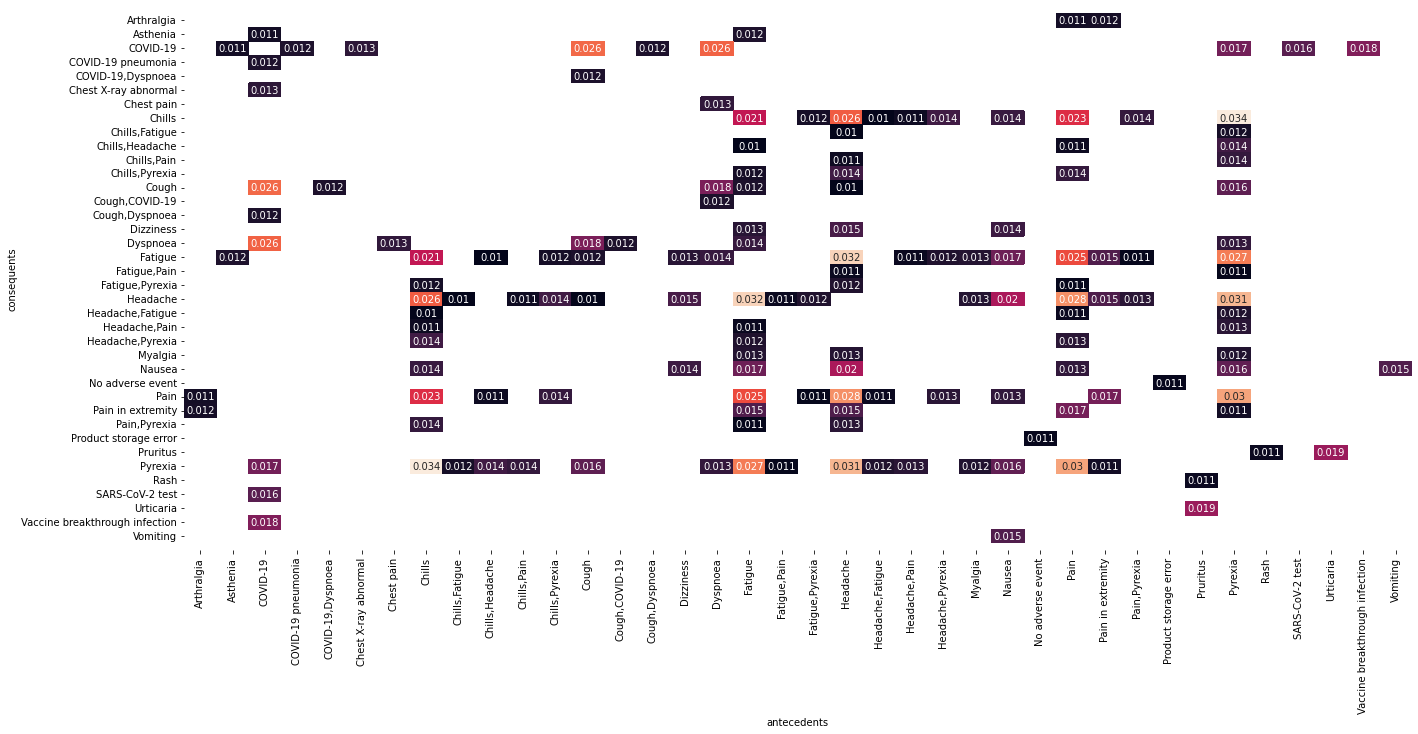

In [ ]:
# Transform antecedent, consequent, and support columns into matrix
support_table = symptom_rules.pivot(index='consequents', columns='antecedents', values='support')

plt.figure(figsize=(22,10))
sns.heatmap(support_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.show() 

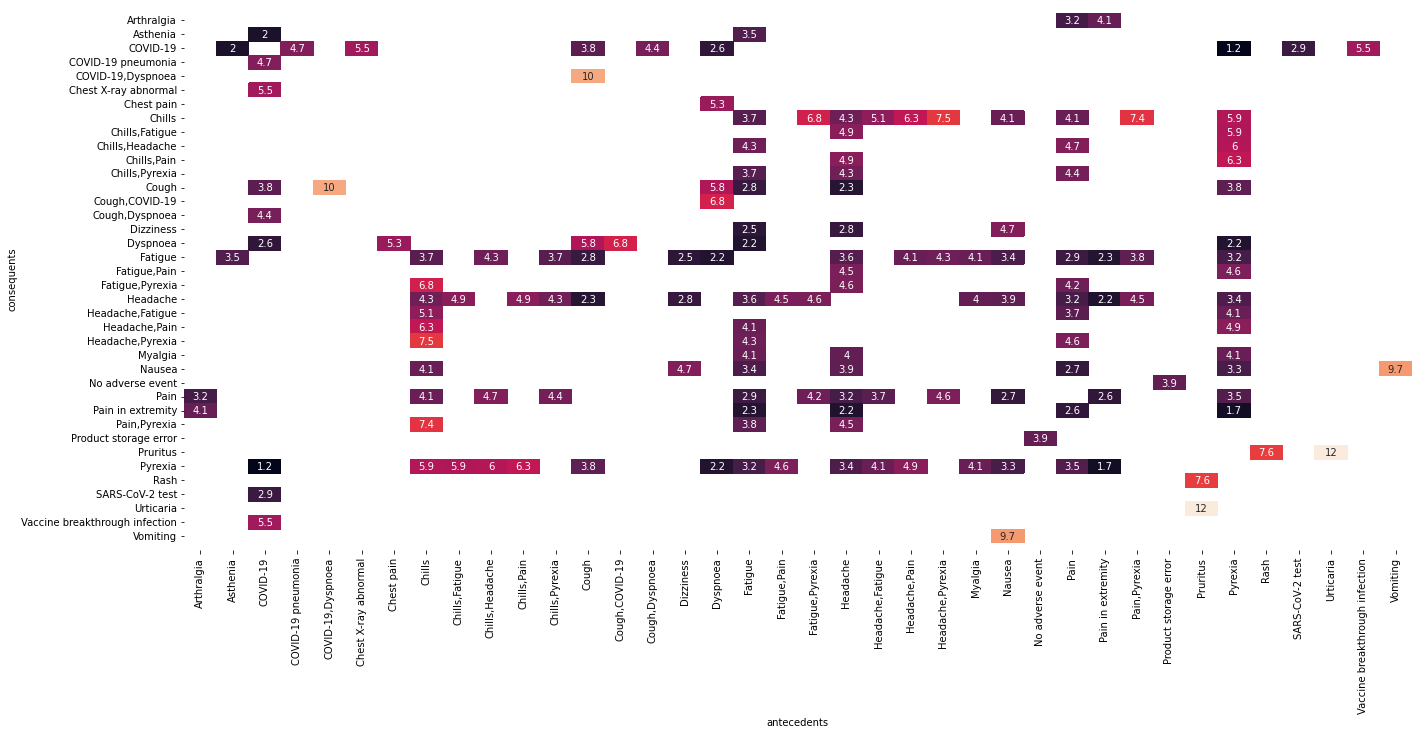

In [ ]:
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = symptom_rules.pivot(index = 'consequents', columns = 'antecedents', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(22,10))
sns.heatmap(pivot, annot = True, cbar = False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

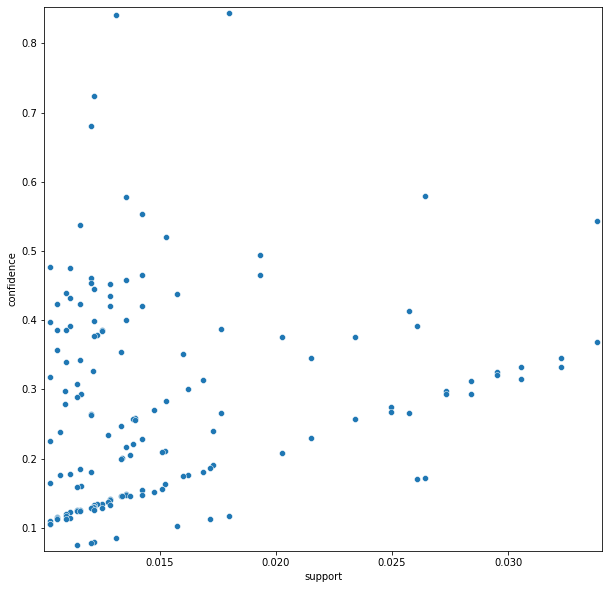

In [ ]:
# Generate scatterplot using support and confidence
plt.figure(figsize=(10,10))
sns.scatterplot(x = "support", y = "confidence", data = symptom_rules)
plt.margins(0.01,0.01)
plt.show()

### 5.3.3. Top 10 symptom rules dis-aggregated by 'SEX'

In [ ]:
gender_rules = association(data=onehot, method="fpgrowth", 
                    drop_group=age_group + ["DIED", "Death", "SARS-CoV-2 test positive"], 
                    min_support=0.01, metric="lift", min_threshold=1)

In [ ]:
gender_rules[gender_rules['consequents'] == 'Male'][['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by=['support'], ascending=False)[:10]

,antecedents,consequents,support,confidence,lift
364,COVID-19,Male,0.065698,0.429441,1.221534
427,Product storage error,Male,0.027539,0.454244,1.292088
380,Dyspnoea,Male,0.026900,0.404501,1.150592
2,No adverse event,Male,0.019144,0.427465,1.215915
332,Cough,Male,0.017410,0.382058,1.086756
0,Expired product administered,Male,0.017355,0.352876,1.003747
415,Chest pain,Male,0.015512,0.413424,1.175975
406,Asthenia,Male,0.014198,0.382686,1.088541
7,SARS-CoV-2 test,Male,0.012884,0.358740,1.020427
391,"COVID-19,Dyspnoea",Male,0.012337,0.473058,1.345603


In [ ]:
gender_rules[gender_rules['consequents'] == 'Female'][['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by=['support'], ascending=False)[:10]

,antecedents,consequents,support,confidence,lift
194,Headache,Female,0.069494,0.716867,1.241474
22,Pain,Female,0.064731,0.711820,1.232733
10,Fatigue,Female,0.063965,0.685776,1.187629
169,Pyrexia,Female,0.059621,0.649374,1.124588
293,Pain in extremity,Female,0.051847,0.718695,1.244638
70,Chills,Female,0.042503,0.682391,1.181767
238,Nausea,Female,0.040587,0.754410,1.306490
377,Dyspnoea,Female,0.038835,0.583974,1.011328
224,Dizziness,Female,0.037685,0.690635,1.196045
236,Urticaria,Female,0.028615,0.689534,1.194137


### 5.3.4. Top 10 symptom rules dis-aggregated by 'AGE'

In [ ]:
age_rules = association(data=onehot, method="fpgrowth",
                        drop_group=gender_group + ["DIED", "Death", "SARS-CoV-2 test positive"], 
                        min_support=0.01, metric="lift", min_threshold=1)

In [ ]:
for age in age_group:
    if not age_rules[age_rules['consequents'] == age].empty:
        display(age_rules[age_rules['consequents'] == age][['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by=['support'], ascending=False)[:10])
        print("-"*100)

,antecedents,consequents,support,confidence,lift
210,Product administered to patient of inappropria...,10 - 19 years,0.015658,0.769507,8.235526
207,Product storage error,10 - 19 years,0.012975,0.214028,2.290598
3,No adverse event,10 - 19 years,0.011497,0.256724,2.747545


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
116,Headache,30 - 39 years,0.014709,0.151732,1.266652
20,Pain,30 - 39 years,0.013851,0.152318,1.271543
105,Pyrexia,30 - 39 years,0.013267,0.144504,1.206314
15,Fatigue,30 - 39 years,0.012884,0.138133,1.153132
136,Urticaria,30 - 39 years,0.011424,0.275286,2.298075


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
29,Pain,40 - 49 years,0.016169,0.177805,1.441269
114,Headache,40 - 49 years,0.016078,0.165851,1.344374
11,Fatigue,40 - 49 years,0.015019,0.161025,1.305257
103,Pyrexia,40 - 49 years,0.013048,0.142119,1.152004
159,Pain in extremity,40 - 49 years,0.010749,0.149001,1.207788


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
91,COVID-19,50 - 59 years,0.020804,0.135990,1.002918
118,Headache,50 - 59 years,0.017447,0.179970,1.327272
19,Pain,50 - 59 years,0.017319,0.190448,1.404544
7,Fatigue,50 - 59 years,0.016771,0.179808,1.326080
97,Pyrexia,50 - 59 years,0.015640,0.170344,1.256280
153,Pain in extremity,50 - 59 years,0.013085,0.181381,1.337680
58,Chills,50 - 59 years,0.011753,0.188690,1.391585
185,Dyspnoea,50 - 59 years,0.010566,0.158891,1.171818


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
130,COVID-19,60 - 69 years,0.026243,0.171538,1.325377
120,Headache,60 - 69 years,0.014946,0.154179,1.191258
12,Fatigue,60 - 69 years,0.014399,0.154373,1.192755
100,Pyrexia,60 - 69 years,0.014143,0.154045,1.190221
26,Pain,60 - 69 years,0.013267,0.145896,1.127259
160,Pain in extremity,60 - 69 years,0.011406,0.158108,1.221612
192,Dyspnoea,60 - 69 years,0.011205,0.168496,1.301878


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
48,COVID-19,70 - 79 years,0.028013,0.183109,2.025767
190,Dyspnoea,70 - 79 years,0.010530,0.158342,1.751774


----------------------------------------------------------------------------------------------------


,antecedents,consequents,support,confidence,lift
205,COVID-19,80 - 89 years,0.019381,0.126685,3.002521


----------------------------------------------------------------------------------------------------


### 5.3.5. Top 10 symptom rules dis-aggregated by "DIED" status

In [ ]:
death_rules = association(data=onehot[onehot["DIED"] == True], method="fpgrowth",
                    drop_group=["Death", "SARS-CoV-2 test positive"], 
                    min_support=0.01, metric="lift", min_threshold=1)

death_rules[death_rules['consequents'] == 'DIED'][['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by=['support'], ascending=False)[:10]

,antecedents,consequents,support,confidence,lift
13013,COVID-19,DIED,0.557132,1.0,1.0
1,Male,DIED,0.528006,1.0,1.0
12805,Female,DIED,0.409261,1.0,1.0
5,"Male,COVID-19",DIED,0.310680,1.0,1.0
12947,70 - 79 years,DIED,0.259895,1.0,1.0
12810,"Female,COVID-19",DIED,0.241225,1.0,1.0
3835,Dyspnoea,DIED,0.218073,1.0,1.0
4084,80 - 89 years,DIED,0.215086,1.0,1.0
12982,"COVID-19,70 - 79 years",DIED,0.171023,1.0,1.0
3869,"COVID-19,Dyspnoea",DIED,0.170276,1.0,1.0
